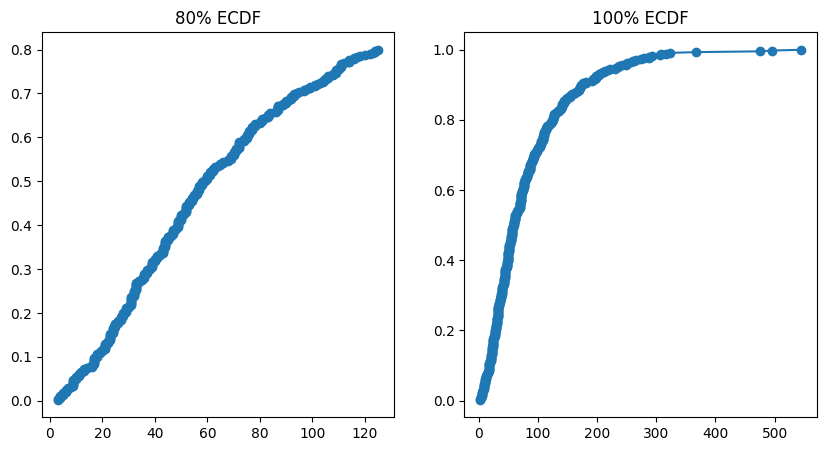

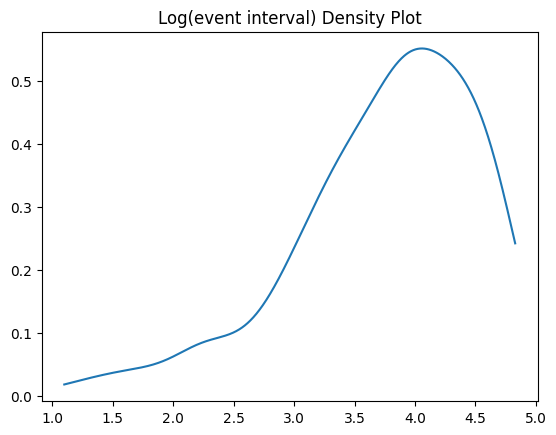

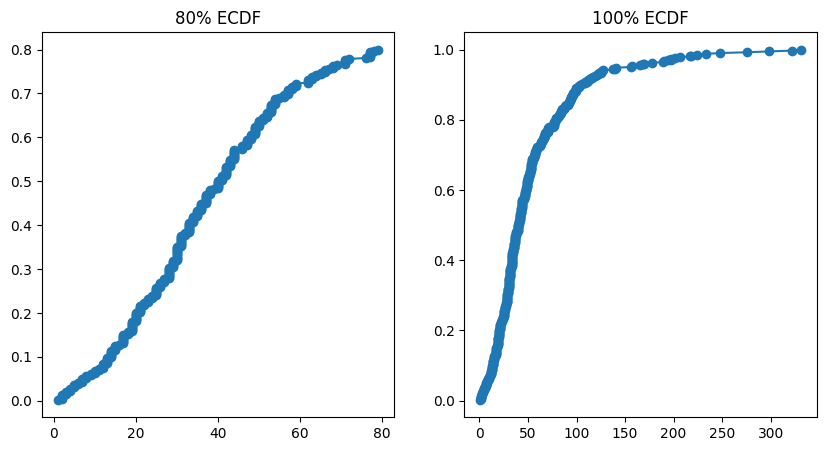

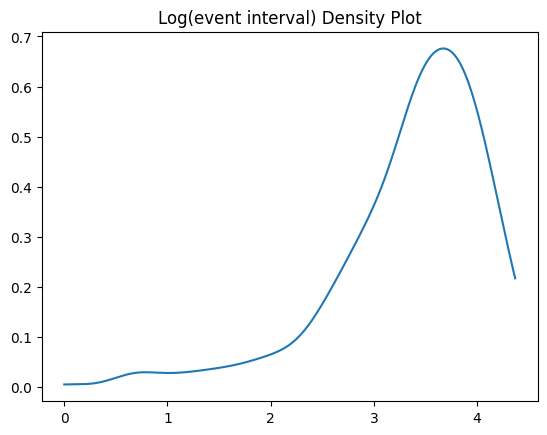

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset (ensure the CSV file is in the correct location)
tidy = pd.read_csv("med_events.csv")

# Rename columns to match the expected format
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

def see(arg1):
    drug_data = tidy[tidy['ATC'] == arg1].copy()
    drug_data.sort_values(by=['pnr', 'eksd'], inplace=True)
    drug_data['prev_eksd'] = drug_data.groupby('pnr')['eksd'].shift(1)
    drug_data.dropna(subset=['prev_eksd'], inplace=True)
    drug_data['event_interval'] = (drug_data['eksd'] - drug_data['prev_eksd']).dt.days
    
    # **Ensure event_interval has no zeros or negative values**
    drug_data = drug_data[drug_data['event_interval'] > 0]
    
    if drug_data.empty:
        print(f"No valid event intervals for {arg1}. Returning empty DataFrame.")
        return pd.DataFrame()
    
    # Empirical CDF
    x = np.sort(drug_data['event_interval'])
    y = np.arange(1, len(x) + 1) / len(x)
    df_ecdf = pd.DataFrame({'x': x, 'y': y})
    df_ecdf = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf['x'].max()
    
    # Plot ECDF
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_ecdf['x'], df_ecdf['y'], marker='o')
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, marker='o')
    plt.title("100% ECDF")
    plt.show()
    
    # Filter data based on the ECDF threshold
    drug_data_filtered = drug_data[drug_data['event_interval'] <= ni].copy()  # **Use .copy() to avoid slice issues**
    
    # **Check again after filtering**
    if drug_data_filtered.empty:
        print(f"No valid filtered data for {arg1}. Returning empty DataFrame.")
        return pd.DataFrame()
    
    # Log transformation and density plot
    log_intervals = np.log(drug_data_filtered['event_interval'])
    
    # **Check if log_intervals contains NaN or inf values**
    log_intervals = log_intervals.replace([np.inf, -np.inf], np.nan).dropna()
    
    if log_intervals.empty:
        print(f"Log transformation resulted in empty data for {arg1}. Returning empty DataFrame.")
        return pd.DataFrame()
    
    # Kernel Density Estimation (KDE)
    density = gaussian_kde(log_intervals)
    x_vals = np.linspace(log_intervals.min(), log_intervals.max(), 1000)
    y_vals = density(x_vals)
    
    plt.figure()
    plt.plot(x_vals, y_vals)
    plt.title("Log(event interval) Density Plot")
    plt.show()
    
    # Clustering using silhouette score
    scaled_data = StandardScaler().fit_transform(log_intervals.values.reshape(-1, 1))
    best_k = 2
    best_score = -1
    for k in range(2, 6):
        kmeans = KMeans(n_clusters=k, random_state=1234)
        labels = kmeans.fit_predict(scaled_data)
        score = silhouette_score(scaled_data, labels)
        if score > best_score:
            best_k, best_score = k, score
    
    # Final clustering
    kmeans = KMeans(n_clusters=best_k, random_state=1234)
    clusters = kmeans.fit_predict(scaled_data)
    
    # **Fix the SettingWithCopyWarning by using .loc[]**
    drug_data_filtered.loc[:, 'Cluster'] = clusters  # Use .loc[] to ensure safe assignment
    
    # Compute min, max, median per cluster
    cluster_stats = drug_data_filtered.groupby('Cluster')['event_interval'].agg(['min', 'max', 'median']).reset_index()
    cluster_stats['median'] = np.exp(cluster_stats['median'])
    
    # Merge cluster statistics back into original data
    drug_data = drug_data_filtered.merge(cluster_stats, on='Cluster', how='left')
    
    # **Fix the fillna() warning by assigning the result explicitly**
    drug_data['median'] = drug_data['median'].fillna(cluster_stats['median'].median())
    
    return drug_data

# Apply function for specific drugs
medA = see("medA")
medB = see("medB")
